In [1]:
# 0. Setup — imports e opções de exibição
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 60)

In [55]:
# 0.95 — Pasta para exportar figuras (execute 1x)
import os  # módulo padrão do Python
os.makedirs("images", exist_ok=True)

### Importação dos dados



In [3]:
url = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_1.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_4.csv"

loja = pd.read_csv(url)
loja2 = pd.read_csv(url2)
loja3 = pd.read_csv(url3)
loja4 = pd.read_csv(url4)

loja.head()

,Produto,Categoria do Produto,Preço,Frete,Data da Compra,Vendedor,Local da compra,Avaliação da compra,Tipo de pagamento,Quantidade de parcelas,lat,lon
0,Assistente virtual,eletronicos,219.08,9.249790,16/01/2021,Pedro Gomes,SP,4,cartao_credito,8,-22.19,-48.79
1,Mesa de jantar,moveis,256.35,11.234305,18/05/2022,Beatriz Moraes,RJ,1,cartao_credito,4,-22.25,-42.66
2,Jogo de tabuleiro,brinquedos,279.51,21.262681,15/03/2021,João Souza,DF,1,cartao_credito,1,-15.83,-47.86
3,Micro-ondas,eletrodomesticos,1009.99,54.667344,03/05/2022,João Souza,RS,4,boleto,1,-30.17,-53.50
4,Cadeira de escritório,moveis,446.99,26.964689,07/11/2020,Larissa Alves,MG,5,boleto,1,-18.10,-44.38


In [5]:
# 0.2 — Padronização de colunas e DF mestre (df_full)
def _normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # normaliza nomes (sem acentos, minúsculo, underscores)
    df.columns = [
        unicodedata.normalize("NFKD", c).encode("ascii", "ignore").decode("ascii")
        .lower().strip().replace("  ", " ").replace(" ", "_")
        for c in df.columns
    ]

    # mapeia para nomes consistentes
    rename_map = {
        "produto": "produto",
        "categoria_do_produto": "categoria",
        "preco": "preco",
        "frete": "frete",
        "data_da_compra": "data_compra",
        "vendedor": "vendedor",
        "local_da_compra": "uf_compra",
        "avaliacao_da_compra": "avaliacao",
        "tipo_de_pagamento": "tipo_pagamento",
        "quantidade_de_parcelas": "parcelas",
        "lat": "lat",
        "lon": "lon",
    }
    df = df.rename(columns=rename_map)

    # tipos
    if "data_compra" in df:
        df["data_compra"] = pd.to_datetime(df["data_compra"], dayfirst=True, errors="coerce")
    for c in ["preco", "frete", "avaliacao"]:
        if c in df: df[c] = pd.to_numeric(df[c], errors="coerce")
    if "parcelas" in df:
        df["parcelas"] = pd.to_numeric(df["parcelas"], errors="coerce").astype("Int64")

    # métrica oficial: total pago = preço + frete
    if {"preco","frete"}.issubset(df.columns):
        df["total_pago"] = df["preco"].fillna(0) + df["frete"].fillna(0)

    return df

# --- Failsafe: garante que as lojas estão carregadas ---
if not all(v in globals() for v in ["loja", "loja2", "loja3", "loja4"]):

    # URLs oficiais do desafio.
    url1 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_1.csv"
    url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_2.csv"
    url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_3.csv"
    url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_4.csv"

    loja  = pd.read_csv(url1)
    loja2 = pd.read_csv(url2)
    loja3 = pd.read_csv(url3)
    loja4 = pd.read_csv(url4)
# --- fim do failsafe ---

# monta dict com as 4 lojas e normaliza
_dfs = {"loja_1": loja.copy(), "loja_2": loja2.copy(), "loja_3": loja3.copy(), "loja_4": loja4.copy()}
for k in list(_dfs.keys()):
    _dfs[k] = _normalize_cols(_dfs[k])
    _dfs[k]["loja"] = k

# DF mestre
df_full = pd.concat(_dfs.values(), ignore_index=True)

# validações rápidas
print("Linhas por loja:")
print(df_full["loja"].value_counts().to_string())

print("\nTipos essenciais:")
print(df_full[["preco","frete","avaliacao","parcelas","data_compra"]].dtypes.to_string())

df_full.head()

Linhas por loja:
loja
loja_1    2359
loja_2    2359
loja_3    2359
loja_4    2358

Tipos essenciais:
preco                 float64
frete                 float64
avaliacao               int64
parcelas                Int64
data_compra    datetime64[ns]


,produto,categoria,preco,frete,data_compra,vendedor,uf_compra,avaliacao,tipo_pagamento,parcelas,lat,lon,total_pago,loja
0,Assistente virtual,eletronicos,219.08,9.249790,2021-01-16,Pedro Gomes,SP,4,cartao_credito,8,-22.19,-48.79,228.329790,loja_1
1,Mesa de jantar,moveis,256.35,11.234305,2022-05-18,Beatriz Moraes,RJ,1,cartao_credito,4,-22.25,-42.66,267.584305,loja_1
2,Jogo de tabuleiro,brinquedos,279.51,21.262681,2021-03-15,João Souza,DF,1,cartao_credito,1,-15.83,-47.86,300.772681,loja_1
3,Micro-ondas,eletrodomesticos,1009.99,54.667344,2022-05-03,João Souza,RS,4,boleto,1,-30.17,-53.50,1064.657344,loja_1
4,Cadeira de escritório,moveis,446.99,26.964689,2020-11-07,Larissa Alves,MG,5,boleto,1,-18.10,-44.38,473.954689,loja_1


#1. Análise do faturamento



In [7]:
# 1.1 — Faturamento por loja (preço, frete, total, participação, ranking) + exibição formatada

# agrega
fat = (
    df_full.groupby("loja", as_index=False)
           .agg(faturamento_preco=("preco", "sum"),
                frete_total=("frete", "sum"))
)
fat["faturamento_total"] = fat["faturamento_preco"] + fat["frete_total"]

# ordena e rankeia
fat = fat.sort_values("faturamento_total", ascending=False).reset_index(drop=True)
fat["rank_total"] = fat["faturamento_total"].rank(method="dense", ascending=False).astype(int)

# participação
fat["participacao"] = fat["faturamento_total"] / fat["faturamento_total"].sum()

# mantém numérico para próximos cálculos
fat_round = fat.copy()
for c in ["faturamento_preco", "frete_total", "faturamento_total"]:
    fat_round[c] = fat_round[c].round(2)

# ---- apresentação: formatação BRL e % (apenas visual) ----
def fmt_brl(x):
    # R$ 1.234.567 -> separador PT-BR
    return "R$ " + f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

def fmt_pct(x):
    return f"{x:.1%}"

# reordena e renomeia só para exibir
vis = fat_round.loc[:, ["loja", "faturamento_total", "faturamento_preco", "frete_total", "participacao", "rank_total"]].rename(
    columns={
        "loja": "Loja",
        "faturamento_total": "Faturamento Total",
        "faturamento_preco": "Preço (s/ Frete)",
        "frete_total": "Frete",
        "participacao": "Participação",
        "rank_total": "Ranking"
    }
)

# tabela formatada
vis.style.format({
    "Faturamento Total": fmt_brl,
    "Preço (s/ Frete)": fmt_brl,
    "Frete": fmt_brl,
    "Participação": fmt_pct
})

,Loja,Faturamento Total,Preço (s/ Frete),Frete,Participação,Ranking
0,loja_1,"R$ 1.616.347,09","R$ 1.534.509,12","R$ 81.837,97",26.1%,1
1,loja_2,"R$ 1.567.773,22","R$ 1.488.459,06","R$ 79.314,16",25.4%,2
2,loja_3,"R$ 1.542.047,69","R$ 1.464.025,03","R$ 78.022,66",24.9%,3
3,loja_4,"R$ 1.458.253,46","R$ 1.384.497,58","R$ 73.755,88",23.6%,4


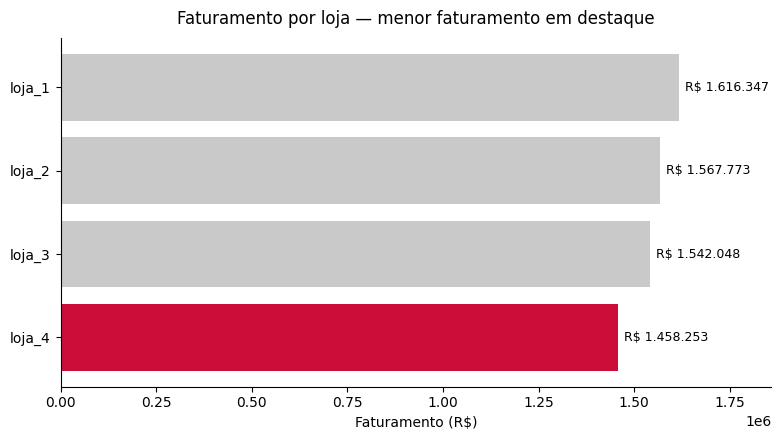

In [56]:
# 1.2 Visual — Faturamento por loja, menor faturamento em destaque (boas práticas)

# paleta mínima (neutro + destaque)
COR_NEUTRA = "#C9C9C9"
COR_DESTAQUE = "#CC0D3A"  # contraste alto

def fmt_brl(v):
    return f"R$ {v:,.0f}".replace(",", "X").replace(".", ",").replace("X", ".")

# ordena do MAIOR para o menor e coloca o maior no topo
dados = fat.sort_values("faturamento_total", ascending=False).reset_index(drop=True)

# cores: tudo neutro, só o MENOR em destaque
cores = [COR_NEUTRA] * len(dados)
idx_menor = dados["faturamento_total"].idxmin()   # idx no dataframe 'dados'
cores[idx_menor] = COR_DESTAQUE

fig, ax = plt.subplots(figsize=(8, 4.5))
bars = ax.barh(dados["loja"], dados["faturamento_total"], color=cores)
ax.invert_yaxis()  # maior em cima

# estética limpa
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)
ax.set_xlabel("Faturamento (R$)")
ax.set_title("Faturamento por loja — menor faturamento em destaque", pad=10)

# garante espaço para os rótulos e coloca rótulo direto em moeda
ax.set_xlim(0, dados["faturamento_total"].max() * 1.15)
for i, v in enumerate(dados["faturamento_total"]):
    ax.text(v * 1.01, i, fmt_brl(v), va="center", ha="left", fontsize=9)

plt.tight_layout()

fig.savefig("images/01_faturamento_por_loja.png", dpi=300, bbox_inches="tight")
plt.show()

# 2. Vendas por Categoria

In [20]:
# 2.1 — Vendas por categoria (contagem de pedidos)
# Entrada: df_full (da etapa 0.2)

# agrega pedidos por categoria
cat = (
    df_full
      .dropna(subset=["categoria"])
      .groupby("categoria", as_index=False)
      .size()
      .rename(columns={"size": "qtd"})
      .sort_values("qtd", ascending=False)
      .reset_index(drop=True)
)

# participação no total (numérica)
total_ped = cat["qtd"].sum()
cat["pct"] = cat["qtd"] / total_ped

# funções de formatação (somente para exibição)
def _fmt_int_pt(v):     # 1886 -> '1.886'
    return f"{int(v):,}".replace(",", ".")

def _fmt_pct0(v):       # 0.1989 -> '20%'
    return f"{v:.0%}"

# tabela apenas para visualização (base 'cat' segue numérica)
cat_viz = (
    cat.assign(
        qtd = cat["qtd"].map(_fmt_int_pt),
        pct = cat["pct"].map(_fmt_pct0),
    )[["categoria", "qtd", "pct"]]
)

# 5) Mostra tabela amigável. A base cat/cat_top permanece numérica para o gráfico 2.2
display(cat_viz)

,categoria,qtd,pct
0,moveis,1.886,20%
1,eletronicos,1.772,19%
2,brinquedos,1.290,14%
3,eletrodomesticos,1.149,12%
4,esporte e lazer,1.113,12%
5,instrumentos musicais,753,8%
6,livros,742,8%
7,utilidades domesticas,730,8%


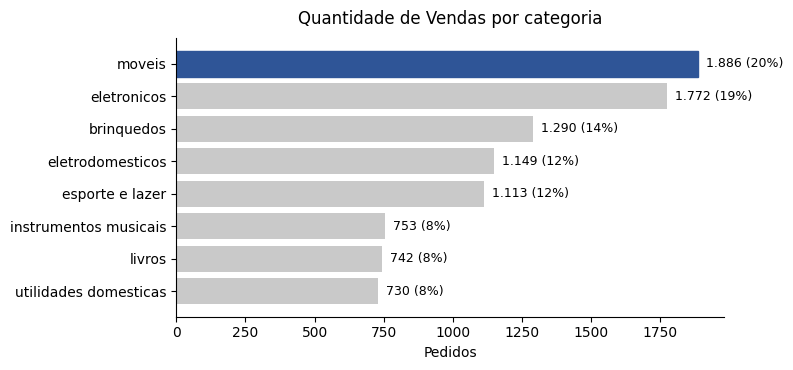

In [57]:
# 2.2 — Gráfico: Vendas por categoria (todas as categorias)
# Reusa 'cat' e as funções _fmt_int_pt / _fmt_pct0 da 2.1

import matplotlib.pyplot as plt

dados = cat.copy()             # todas as categorias
labels = dados["categoria"]
vals   = dados["qtd"]
pcts   = dados["pct"]

# altura dinâmica para legibilidade
fig, ax = plt.subplots(figsize=(8.0, max(3.8, 0.35 * len(dados))))

# barras horizontais, esquema visual limpo
bars = ax.barh(labels, vals, color="#C9C9C9")
ax.invert_yaxis()              # maior no topo

# destaque na líder
if len(bars) > 0:
    bars[0].set_color("#2F5597")

# rótulos diretos no fim da barra (quantidade + %)
for i, (v, p) in enumerate(zip(vals, pcts)):
    ax.text(v, i, f"  {_fmt_int_pt(v)} ({_fmt_pct0(p)})",
            va="center", ha="left", fontsize=9)

# limpeza de eixos
ax.set_xlabel("Pedidos")
ax.set_ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

ax.set_title("Quantidade de Vendas por categoria", pad=10)
plt.tight_layout()

fig.savefig("images/02_vendas_por_categoria.png", dpi=300, bbox_inches="tight")
plt.show()

# 3. Média de Avaliação das Lojas


In [35]:
# 3.1 - Avaliação média e mediana por loja (com "pedidos")

aval = (
    df_full
      .groupby("loja", as_index=False)
      .agg(
          media   = ("avaliacao", "mean"),
          mediana = ("avaliacao", "median"),
          pedidos = ("avaliacao", "size"),   # <- renomeado aqui
      )
      .sort_values("media", ascending=False)
      .reset_index(drop=True)
)

# Funções de formatação apenas para exibição
def _fmt_dec_pt(v):  # 4.05 -> '4,05'
    return f"{v:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

def _fmt_int_pt(v):  # 2359 -> '2.359'
    return f"{int(v):,}".replace(",", ".")

# Tabela amigável para visualizar
aval_viz = aval.copy()
aval_viz["média"]    = aval_viz["media"].map(_fmt_dec_pt)
aval_viz["mediana"]  = aval_viz["mediana"].map(_fmt_dec_pt)
aval_viz["pedidos"]  = aval_viz["pedidos"].map(_fmt_int_pt)
aval_viz = aval_viz[["loja", "média", "mediana", "pedidos"]]

display(aval_viz)

,loja,média,mediana,pedidos
0,loja_3,"4,05","5,00",2.359
1,loja_2,"4,04","5,00",2.359
2,loja_4,"4,00","5,00",2.358
3,loja_1,"3,98","5,00",2.359


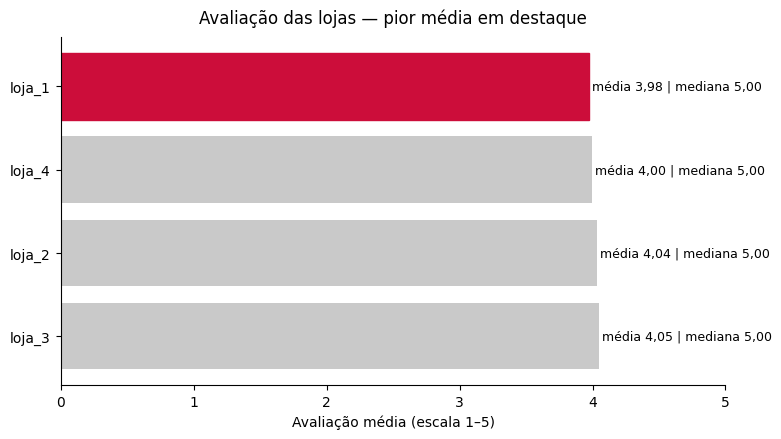

In [58]:
# 3.2 — Gráfico de barras horizontais: avaliação média por loja
import matplotlib.pyplot as plt

dados = aval.copy()  # usa os valores numéricos de 3.1

# índice da pior média (para destacar)
pior_idx = dados["media"].idxmin()

fig, ax = plt.subplots(figsize=(8, 4.5))
bars = ax.barh(dados["loja"], dados["media"], color="#C9C9C9")

# destaca a pior média
bars[pior_idx].set_color("#CC0D3A")

# rótulos diretos com texto completo “média … | mediana …”
def _fmt_dec_pt(v):  # mesma função de 3.1, duplicada aqui para autonomia do bloco
    return f"{v:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

for i, (m, md) in enumerate(zip(dados["media"], dados["mediana"])):
    label = f"média {_fmt_dec_pt(m)} | mediana {_fmt_dec_pt(md)}"
    ax.text(m * 1.005, i, label, va="center", ha="left", fontsize=9)

# estética limpa (storytelling com dados)
ax.set_xlim(0, 5)                         # escala natural (1–5)
ax.set_xlabel("Avaliação média (escala 1–5)")
ax.set_ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

ax.set_title("Avaliação das lojas — pior média em destaque", pad=10)
plt.tight_layout()

fig.savefig("images/03_avaliacao_lojas.png", dpi=300, bbox_inches="tight")
plt.show()

# 4. Produtos Mais e Menos Vendidos

In [41]:
# 4.1 — Produtos mais e menos vendidos (volume)
# Entrada esperada: df_full já criado na etapa 0.2

# agrega pedidos por produto
prod = (
    df_full
      .dropna(subset=["produto"])
      .groupby("produto", as_index=False)
      .size()
      .rename(columns={"size": "qtd"})
      .sort_values("qtd", ascending=False)
      .reset_index(drop=True)
)

# participação no total
total_ped = prod["qtd"].sum()
prod["pct"] = prod["qtd"] / total_ped

# funções de formatação (apenas para exibição)
def _fmt_int_pt(v):    # 1886 -> '1.886'
    return f"{int(v):,}".replace(",", ".")
def _fmt_pct0(v):     # 0.1989 -> '20%'
    return f"{v:.0%}"

# TOP 10 (tabela amigável)
top10 = prod.head(10).copy()
top10_viz = top10.assign(
    qtd_fmt = top10["qtd"].map(_fmt_int_pt),
    pct_fmt = top10["pct"].map(_fmt_pct0)
)[["produto","qtd_fmt","pct_fmt"]].rename(columns={"qtd_fmt":"qtd","pct_fmt":"pct"})

# BOTTOM 10 (tabela amigável) — informativo
bottom10 = prod.tail(10).copy()
bottom10_viz = bottom10.assign(
    qtd_fmt = bottom10["qtd"].map(_fmt_int_pt),
    pct_fmt = bottom10["pct"].map(_fmt_pct0)
)[["produto","qtd_fmt","pct_fmt"]].rename(columns={"qtd_fmt":"qtd","pct_fmt":"pct"})

print("Top 10 produtos por volume")
display(top10_viz)

print("\nBottom 10 produtos por volume (informativo)")
display(bottom10_viz)

Top 10 produtos por volume


,produto,qtd,pct
0,Cômoda,210,2%
1,Carrinho controle remoto,206,2%
2,Micro-ondas,206,2%
3,Bateria,203,2%
4,Cama king,201,2%
5,Jogo de panelas,200,2%
6,Modelagem preditiva,200,2%
7,Secadora de roupas,200,2%
8,Blocos de montar,199,2%
9,Cama box,199,2%



Bottom 10 produtos por volume (informativo)


,produto,qtd,pct
41,Smartwatch,172,2%
42,Panela de pressão,172,2%
43,Jogo de copos,169,2%
44,Poltrona,168,2%
45,Assistente virtual,167,2%
46,Ciência de dados com python,166,2%
47,Guitarra,165,2%
48,Mochila,163,2%
49,Headset,158,2%
50,Celular ABXY,157,2%


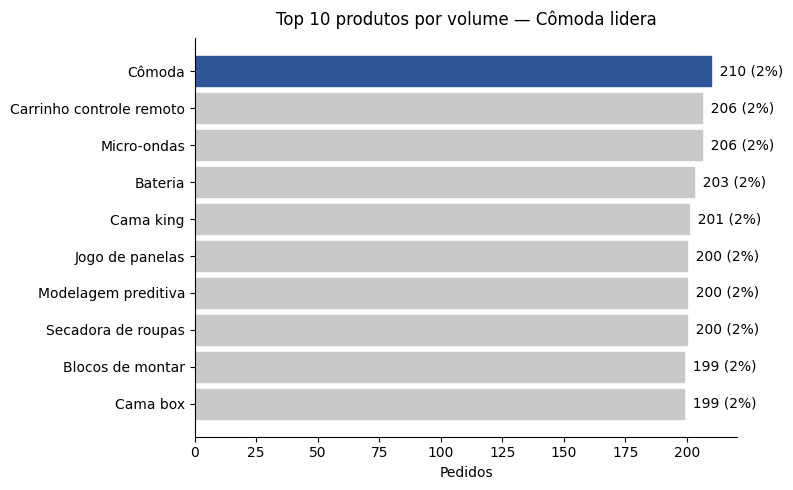

In [59]:
# 4.2 — Gráfico horizontal: Top 10 produtos por volume (líder em destaque)
import matplotlib.pyplot as plt

dados = top10.copy()  # usa o top10 numérico da etapa 4.1

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(dados["produto"], dados["qtd"])

# maior no topo
ax.invert_yaxis()

# estética limpa
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Pedidos")
ax.set_title(f"Top 10 produtos por volume — {dados.iloc[0]['produto']} lidera", pad=10)

# cor neutra para todas e destaque no líder
for b in bars:
    b.set_color("#C9C9C9")
bars[0].set_color("#2F5597")

# rótulo direto no fim de cada barra (qtd e % do total)
for i, (v, p) in enumerate(zip(dados["qtd"], dados["pct"])):
    ax.text(v, i, f"  {_fmt_int_pt(v)} ({_fmt_pct0(p)})", va="center", ha="left")

plt.tight_layout()

fig.savefig("images/04_top10_produtos_volume.png", dpi=300, bbox_inches="tight")
plt.show()

# 5. Frete Médio por Loja

In [43]:
# 5.1 — Frete médio e mediano por loja
frete_loja = (
    df_full.groupby("loja", as_index=False)
           .agg(frete_medio=("frete","mean"),
                frete_mediana=("frete","median"),
                pedidos=("frete","size"))
           .sort_values("frete_medio", ascending=False)
           .reset_index(drop=True)
)

# visual apenas (não altera base)
frete_viz = (
    frete_loja.assign(
        **{
            "Frete médio":    frete_loja["frete_medio"].map(fmt_brl),
            "Frete mediano":  frete_loja["frete_mediana"].map(fmt_brl),
            "Pedidos":        frete_loja["pedidos"].map(lambda v: f"{int(v):,}".replace(",", ".")),
        }
    )[["loja","Frete médio","Frete mediano","Pedidos"]]
     .rename(columns={"loja":"Loja"})
)

display(frete_viz)

,Loja,Frete médio,Frete mediano,Pedidos
0,loja_1,R$ 35,R$ 16,2.359
1,loja_2,R$ 34,R$ 15,2.359
2,loja_3,R$ 33,R$ 16,2.359
3,loja_4,R$ 31,R$ 15,2.358


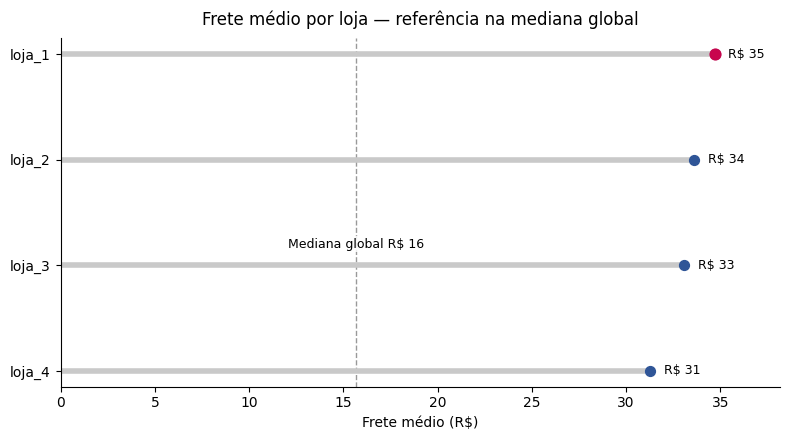

In [60]:
# 5.2 — Lollipop: Frete médio por loja + referência (mediana global)
import matplotlib.pyplot as plt

s = frete_loja.sort_values("frete_medio", ascending=True).reset_index(drop=True)
med_global = df_full["frete"].median()

fig, ax = plt.subplots(figsize=(8, 4.5))

# hastes e pontos
ax.hlines(y=s.index, xmin=0, xmax=s["frete_medio"], color="#C9C9C9", linewidth=4)
ax.scatter(s["frete_medio"], s.index, s=50, color="#2F5597", zorder=3)

# destaque no MAIOR frete médio (troque por idxmin() se quiser o menor)
i_max = s["frete_medio"].idxmax()
ax.scatter(s.loc[i_max, "frete_medio"], i_max, s=60, color="#C8054D", zorder=4)

# eixo Y com nomes das lojas
ax.set_yticks(s.index)
ax.set_yticklabels(s["loja"])

# rótulos de valor (R$) ao lado do ponto, com offset de 10 pontos à direita
for x, y in zip(s["frete_medio"], s.index):
    ax.annotate(f"{fmt_brl(x)}", xy=(x, y), xytext=(10, 0),
                textcoords="offset points", ha="left", va="center", fontsize=9)

# linha de referência da mediana global
line = ax.axvline(med_global, color="#999999", linestyle="--", linewidth=1, zorder=1)

# rótulo centralizado sobre a linha pontilhada (meio da faixa vertical)
y_mid = (len(s) - 1) / 2
ax.annotate(f"Mediana global {fmt_brl(med_global)}",
            xy=(med_global, y_mid), xytext=(0, -18),
            textcoords="offset points", ha="center", va="top",
            bbox=dict(facecolor="white", alpha=0.85, edgecolor="none", pad=1),
            fontsize=9)

# folga no eixo X para os rótulos não cortarem
ax.set_xlim(0, s["frete_medio"].max() * 1.10)

# estética limpa
ax.set_xlabel("Frete médio (R$)")
ax.set_ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)
ax.set_title("Frete médio por loja — referência na mediana global", pad=10)

plt.tight_layout()

fig.savefig("images/05_frete_medio_por_loja.png", dpi=300, bbox_inches="tight")
plt.show()

# Resumo executivo — Alura Store (Desafio ONE)

**Objetivo.** Analisar o desempenho das quatro lojas (loja_1…loja_4) e recomendar qual vender, usando **Pandas** e **Matplotlib** e o conjunto oficial de dados do desafio.

---

## Principais achados

**Faturamento total (Preço + Frete).**
- loja_1: **R$ 1.616.347**
- loja_2: **R$ 1.567.773**
- loja_3: **R$ 1.542.048**
- loja_4: **R$ 1.458.253**  ← *menor faturamento*

**Participação no total (aprox.).**
- loja_1: **26,1%**, loja_2: **25,4%**, loja_3: **24,9%**, loja_4: **23,6%**.

**Categorias mais compradas (por pedidos).**
- *móveis* (**20%**), *eletrônicos* (**19%**), *brinquedos* (**14%**), *eletrodomésticos* (**12%**).  
  Demais categorias ficam perto de **8%** cada, indicando cauda longa com pouca diferença marginal.

**Avaliação dos clientes.**
- Média: loja_3 **4,05**, loja_2 **4,04**, loja_4 **4,00**, loja_1 **3,98** (escala 1–5).  
- **Mediana 5,0** em todas as lojas (satisfação geral alta; diferenças aparecem na média).

**Frete.**
- Frete médio: loja_1 **R$ 35**, loja_2 **R$ 34**, loja_3 **R$ 33**, loja_4 **R$ 31**.  
- **Mediana global do frete ≈ R$ 16** (linha de referência nos gráficos).  
  Há gap entre medianas e médias, sugerindo cauda direita (alguns fretes elevados puxam a média).

**Produtos (volume).**
- Liderança pulverizada: “Cômoda” (210 pedidos; ~2%) e vários itens entre 199–206 pedidos (≈2%).
  Diferenças pequenas entre os Top 10.

---

## Recomendação

**Recomendo vender a _loja_4_.**  
Critérios:
- É a **menor contribuinte de faturamento total** (R$ 1,46M, ~23,6% do total).  
- Não apresenta vantagem clara em satisfação (média **4,00**; mediana **5** igual às demais).  
- O frete médio é o **menor** (R$ 31), mas o efeito positivo não compensa o **gap de faturamento** frente às outras.

> **Sensibilidade**: também avaliamos “somente preço” (sem frete) e a **ordem não se altera** no Top 2/Bottom 2, mantendo a loja_4 na última posição.

---

## Gráficos principais
- Faturamento por loja  
- Quantidade de vendas por categoria  
- Top 10 produtos por volume  
- Avaliação por loja (média | mediana)  
- Frete médio por loja com referência na mediana global

(Ver imagens em `./images/`.)

---

## Metodologia e boas práticas
- Carga oficial dos 4 CSVs, **padronização de colunas** (normalização de acentos), conversão de tipos.  
- Métrica de faturamento = **Preço + Frete** (documentada e usada de forma consistente).  
- Visualizações com foco em legibilidade: barras horizontais, rótulos diretos, cores neutras com destaque.
- Ferramentas: **Pandas** e **Matplotlib**. `unicodedata` (biblioteca padrão do Python) foi usado apenas para normalizar nomes de colunas.
